In [170]:
from psycopg2.extras import execute_batch
import psycopg2
import pandas as pd
import numpy as np
import string
from psycopg2.extras import execute_batch
import os
import requests
import time
from tqdm.autonotebook import tqdm
import logging
logging.getLogger('prophet').setLevel(logging.ERROR)
import warnings
warnings.filterwarnings('ignore')
import datetime
from tqdm import tqdm_notebook
from multiprocessing import Pool

from sklearn.metrics import r2_score

import seaborn as sns
import matplotlib.pyplot as plt

import category_encoders as ce
from category_encoders.target_encoder import TargetEncoder as ce_TargetEncoder
from category_encoders.woe import WOEEncoder as ce_WOEEncoder
from category_encoders.helmert import HelmertEncoder as ce_HelmertEncoder
from category_encoders.count import CountEncoder as ce_CountEncoder

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import RobustScaler, PolynomialFeatures, Normalizer, StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_log_error, mean_squared_error, r2_score
from sklearn.cluster import SpectralClustering, KMeans

import seaborn as sns

from catboost import CatBoostRegressor
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric

In [8]:
df_issues_train = pd.read_csv("train_issues.csv")
df_comment_train = pd.read_csv("train_comments.csv")

df_issues_test = pd.read_csv("test_issues.csv")
df_comment_test = pd.read_csv("test_comments.csv")

df_issues_test['is_test'] = 1
df_issues_train['is_test'] = 0

df_is = pd.concat([df_issues_train, df_issues_test])
df_com = pd.concat([df_comment_test, df_comment_train])

df_emp = pd.read_csv("employees.csv")

In [9]:
df_issues_train.columns

Index(['id', 'created', 'key', 'summary', 'project_id', 'assignee_id',
       'creator_id', 'overall_worklogs', 'is_test'],
      dtype='object')

In [10]:
as_df = df_emp.add_suffix('_asignee')
cr_df = df_emp.add_suffix('_creator')

In [194]:
full_df = pd.merge(df_is, as_df, how="left", left_on='assignee_id', right_on='id_asignee')
full_df = pd.merge(full_df, cr_df, how="left", left_on='creator_id', right_on='id_creator')
full_df.head()

,id,created,key,summary,project_id,assignee_id,creator_id,overall_worklogs,is_test,id_asignee,...,position_creator,hiring_type_creator,payment_type_creator,salary_calculation_type_creator,english_level_creator,passport_creator,is_nda_signed_creator,is_labor_contract_signed_creator,is_added_to_internal_chats_creator,is_added_one_to_one_creator
0,819952,2019-10-01 05:57:18.000,SM-10678,"UI тесты по заказу ""Добро КейДжи""",5,93,93,1800.0,0,93,...,Разработчик мобильных приложений,staff,fixed,NaN,NaN,1,1,1,1,1
1,819949,2019-10-01 05:59:45.000,SM-10679,"UI тесты раздела ""Профиль""",5,93,93,7200.0,0,93,...,Разработчик мобильных приложений,staff,fixed,NaN,NaN,1,1,1,1,1
2,819947,2019-10-01 06:00:38.000,SM-10680,"UI тесты раздела ""Личный счет""",5,93,93,14400.0,0,93,...,Разработчик мобильных приложений,staff,fixed,NaN,NaN,1,1,1,1,1
3,819943,2019-10-01 06:02:49.000,SM-10682,"UI тесты раздела ""Новости""",5,93,93,900.0,0,93,...,Разработчик мобильных приложений,staff,fixed,NaN,NaN,1,1,1,1,1
4,819941,2019-10-01 06:03:26.000,SM-10683,"UI тесты раздела ""Зоны скидок и доплат""",5,93,93,900.0,0,93,...,Разработчик мобильных приложений,staff,fixed,NaN,NaN,1,1,1,1,1


In [195]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10659 entries, 0 to 10658
Data columns (total 35 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   id                                  10659 non-null  int64  
 1   created                             10659 non-null  object 
 2   key                                 10659 non-null  object 
 3   summary                             10659 non-null  object 
 4   project_id                          10659 non-null  int64  
 5   assignee_id                         10659 non-null  int64  
 6   creator_id                          10659 non-null  int64  
 7   overall_worklogs                    9589 non-null   float64
 8   is_test                             10659 non-null  int64  
 9   id_asignee                          10659 non-null  int64  
 10  active_asignee                      10659 non-null  int64  
 11  full_name_asignee                   10659

In [196]:
column_to_full_drop = ['salary_calculation_type_asignee', 'english_level_asignee', 'salary_calculation_type_creator', 'english_level_creator', 
                       'position_asignee', 'hiring_type_asignee', 'payment_type_asignee',
                      'position_creator', 'hiring_type_creator', 'payment_type_creator'
                      ]
full_df = full_df.drop(columns=column_to_full_drop)
full_df.reset_index(drop=True, inplace=True)

# rep_dict = {1: "Да",
#            0: "Нет"}
# full_df = full_df.replace({"is_nda_signed_asignee": rep_dict,
#                           "is_labor_contract_signed_asignee": rep_dict,
#                           "is_added_to_internal_chats_asignee": rep_dict,
#                           "is_added_one_to_one_asignee": rep_dict,
#                           "is_nda_signed_creator": rep_dict,
#                           "is_labor_contract_signed_creator": rep_dict,
#                           "is_added_to_internal_chats_creator": rep_dict,
#                           "is_added_one_to_one_creator": rep_dict})

column_to_per_drop = ['created','id', 'assignee_id', 'creator_id', 'id_creator', 'id_asignee', 'full_name_asignee', 'full_name_creator', 'is_test']
numerical = [var for var in full_df.drop(columns=column_to_per_drop).columns if full_df[var].dtypes!='O']
categorical = [var for var in full_df.drop(columns=column_to_per_drop).columns if full_df[var].dtypes=='O']

In [219]:
df_com_agg = df_com.groupby('issue_id').agg({'text': lambda x: ' '.join(x)}).reset_index()
df_com_agg

,issue_id,text
0,669666,[https://www.youtube.com/watch?v=tuhOdtsvoNY|h...
1,669670,OK [~accountid:557058:3f7ab89a-8969-4547-90df-...
2,670929,I wasted much time building one graph by using...
3,670930,I encountered a problem with access to `/users...
4,670934,I have read the neo4j documentation and also I...
...,...,...
4419,2170252,В настройки проекта в constance вынес конфиг {...
4420,2171729,"Написал админу Халезину, чтобы настроил DNS за..."
4421,2175459,Решили отказаться от отображения последнего ск...
4422,2176348,"Причину определили, во время демки камеры не о..."


In [220]:
df_com_agg['text'][4]

"I have read the neo4j documentation and also I was able to get all users by using the MERGE clause.\xa0 I learned how relations work in the cypher language.\xa0 And\xa0I added relationships for:\r\n\xa0User->Channel (or Group)\r\n\xa0User->Message\r\n\xa0Message->Channel I'm working on add replies to existing messages."

In [221]:
# full_df = pd.merge(full_df, df_com_agg, how="left", left_on='id', right_on='issue_id')
# full_df.head()

In [222]:
# full_df['com_len'] = 0.
# full_df['com_len'] = full_df.apply(lambda row: len(row['text']), axis = 1)

# viz

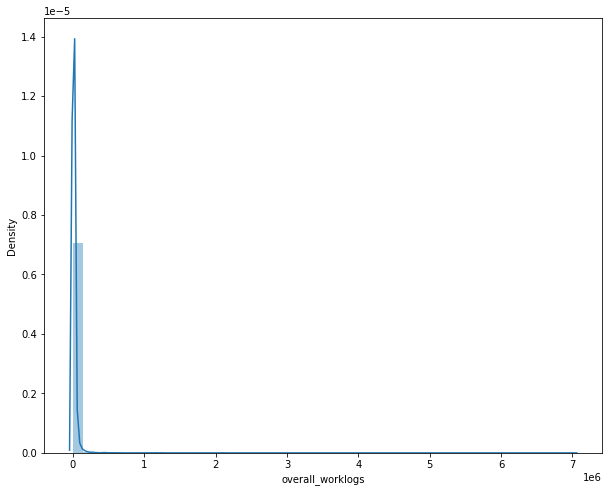

In [223]:
f, ax = plt.subplots(figsize=(10,8))
x = full_df['overall_worklogs']
ax = sns.distplot(x)
plt.show()

# FE

In [224]:
full_df_prep = full_df.copy()

In [225]:
# энкодим ключ проекта
full_df_prep['key'] = full_df_prep.apply(lambda row: row.key.split('-')[0], axis = 1)

In [226]:
from sklearn.preprocessing import LabelEncoder



In [227]:
# энкодим категориальные признаки
sum_l = ['summary']
cat_enc = ce_CountEncoder()
# cat_enc = ce_TargetEncoder()
# cat_enc = ce_WOEEncoder()
# cat_enc = ce_HelmertEncoder()
cat_enc_df = cat_enc.fit_transform(full_df_prep[[ii for ii in categorical if ii not in sum_l]])
full_df_prep[[ii for ii in categorical if ii not in sum_l]] = cat_enc_df

In [228]:
full_df_prep.head()

,id,created,key,summary,project_id,assignee_id,creator_id,overall_worklogs,is_test,id_asignee,...,is_added_to_internal_chats_asignee,is_added_one_to_one_asignee,id_creator,active_creator,full_name_creator,passport_creator,is_nda_signed_creator,is_labor_contract_signed_creator,is_added_to_internal_chats_creator,is_added_one_to_one_creator
0,819952,2019-10-01 05:57:18.000,333,"UI тесты по заказу ""Добро КейДжи""",5,93,93,1800.0,0,93,...,1,1,93,1,Olga Bush,1,1,1,1,1
1,819949,2019-10-01 05:59:45.000,333,"UI тесты раздела ""Профиль""",5,93,93,7200.0,0,93,...,1,1,93,1,Olga Bush,1,1,1,1,1
2,819947,2019-10-01 06:00:38.000,333,"UI тесты раздела ""Личный счет""",5,93,93,14400.0,0,93,...,1,1,93,1,Olga Bush,1,1,1,1,1
3,819943,2019-10-01 06:02:49.000,333,"UI тесты раздела ""Новости""",5,93,93,900.0,0,93,...,1,1,93,1,Olga Bush,1,1,1,1,1
4,819941,2019-10-01 06:03:26.000,333,"UI тесты раздела ""Зоны скидок и доплат""",5,93,93,900.0,0,93,...,1,1,93,1,Olga Bush,1,1,1,1,1


In [229]:
vectorizer = TfidfVectorizer(
    lowercase = False, 
    sublinear_tf=True,
    ngram_range=(1,4),
    max_features=100)

In [230]:
# vectorize summary
# df_vectorized_summary = vectorizer.fit_transform(full_df_prep['summary'])
# df_vectorized_title = pd.DataFrame(df_vectorized_summary.toarray(), columns=vectorizer.get_feature_names())
# df_vectorized_title = df_vectorized_title.add_prefix('summary_')
# full_df_prep = full_df_prep.join(df_vectorized_title)

In [231]:
# vectorize comms
df_vectorized_text = vectorizer.fit_transform(df_com_agg['text'])
df_vectorized_text = pd.DataFrame(df_vectorized_text.toarray(), columns=vectorizer.get_feature_names())
df_vectorized_text = df_vectorized_text.add_prefix('text_')
df_com_agg = df_com_agg.join(df_vectorized_text)

In [232]:
full_df_prep = pd.merge(full_df_prep, df_com_agg.drop(columns=['text']), how="left", left_on='id', right_on='issue_id')

In [233]:
full_df_prep.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10659 entries, 0 to 10658
Columns: 126 entries, id to text_на
dtypes: float64(102), int64(20), object(4)
memory usage: 10.3+ MB


# model train

In [234]:
# plt.rcParams['figure.figsize']=(15,15)

# corr = full_df_model.corr()
# g = sns.heatmap(corr, square = True, annot=True)

In [235]:
full_df_model = full_df_prep.copy()

In [236]:
full_df_test = full_df_model[full_df_model.is_test==1]
full_df_model = full_df_model[full_df_model.is_test==0]

In [237]:
scaler = RobustScaler()
features = full_df_model.drop(column_to_per_drop + ['summary', 'overall_worklogs'], axis=1)
features_cols = list(features.columns)
features = RobustScaler().fit_transform(features.values)
full_df_model[features_cols] = features
X_train, X_test, y_train, y_test = train_test_split(full_df_model.drop(['overall_worklogs'], axis=1),
                                                    full_df_model['overall_worklogs'],
                                                    test_size=0.2,
                                                    random_state=42)

In [238]:
X_train

,id,created,key,summary,project_id,assignee_id,creator_id,is_test,id_asignee,active_asignee,...,text_teacherly teacherly https gitlab,text_the,text_this,text_this issue,text_this issue in,text_this issue in commit,text_to,text_we,text_with,text_на
7706,700135,2019-12-18 04:39:39.000,-1.022857,Верстка страницы для сообщения отсутствия мини...,2.0,242,242,0,242,-1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3834,726329,2020-03-20 15:07:51.868,0.000000,Add spinner into profile buttons,0.0,86,33,0,86,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4091,726011,2020-04-09 13:45:33.767,0.000000,Notifications dropdown,0.0,365,365,0,365,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8827,686898,2020-06-18 08:38:50.000,-1.019571,Customer Feedback 139-160,20.0,1,58,0,1,0.0,...,0.0,0.000000,1.112706,0.107281,0.113499,0.114515,0.084276,0.0,0.0,0.0
9148,703480,2020-04-10 10:39:10.000,-1.066429,Remove livechat minerva,35.0,1,1,0,1,0.0,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5734,723970,2020-08-11 07:13:25.659,0.000000,Remove class owner validation in fetch class b...,0.0,10,10,0,10,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5191,724669,2020-07-10 11:27:56.847,0.000000,Test LessonCommentsController:index() method,0.0,4,4,0,4,-1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5390,724416,2020-07-22 13:52:34.515,0.000000,Get and Post student invite endpoints.,0.0,10,10,0,10,0.0,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1.0
860,730222,2018-11-09 05:46:55.473,0.000000,Problem with link form email,0.0,11,197,0,11,0.0,...,0.0,2.897895,0.000000,0.000000,0.000000,0.000000,0.530193,0.0,0.0,0.0


In [245]:
model = CatBoostRegressor(
                            loss_function='RMSE',
#                             learning_rate=0.005,
#                           loss_function='Huber:delta=4.0',
                          logging_level="Silent")
model.fit(X_train.drop(column_to_per_drop + ['summary'], axis=1), y_train)
prediction = model.predict(X_test.drop(column_to_per_drop + ['summary'], axis=1))

In [246]:
score = r2_score(y_test, prediction)
score

0.06857810009383625

0.007291020848983809

# submit

In [247]:
full_df_test['overall_worklogs'] = model.predict(full_df_test.drop(column_to_per_drop + ['summary'], axis=1))

In [248]:
submition = full_df_test[['id', 'overall_worklogs']]

In [249]:
submition.to_csv('submit_new.csv', index=False)

In [250]:
submition

,id,overall_worklogs
9589,675975,18469.607233
9590,675972,9355.403694
9591,675965,10784.224848
9592,675961,10298.965591
9593,675955,10989.811831
...,...,...
10654,702545,11965.031205
10655,702528,10358.469636
10656,702499,87212.994656
10657,702376,87212.994656


In [236]:
a = pd.read_csv("sample_solution.csv")
a

,id,overall_worklogs
0,675975,0
1,675972,0
2,675965,0
3,675961,0
4,675955,0
...,...,...
1065,702545,0
1066,702528,0
1067,702499,0
1068,702376,0


In [271]:
df_com

,comment_id,text,issue_id,author_id
0,76324,I wasted much time building one graph by using...,670929,2
1,75499,почитал статьи по переносу доменов на клаудфей...,675831,112
2,75519,Посмотрел еще раз как переносят сайты на клауд...,675831,112
3,75490,Проверил построчно импортнутые записи в cloudf...,675834,112
4,75442,Хотел найти способ автоматически перенести зап...,675836,112
...,...,...,...,...
13913,65207,[~alexander.medvedev]\n # Fix console errors i...,689203,58
13914,64891,need information from customers if:\n # Do we ...,689220,58
13915,65166,[~marat] that was sorted out already if I reme...,689220,58
13916,65229,"yes, I get sql dump of database and File Stor...",689220,1


In [207]:
full_df[full_df.is_test==1].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1070 entries, 9589 to 10658
Data columns (total 31 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   id                                  1070 non-null   int64  
 1   created                             1070 non-null   object 
 2   key                                 1070 non-null   object 
 3   summary                             1070 non-null   object 
 4   project_id                          1070 non-null   int64  
 5   assignee_id                         1070 non-null   int64  
 6   creator_id                          1070 non-null   int64  
 7   overall_worklogs                    0 non-null      float64
 8   is_test                             1070 non-null   int64  
 9   id_asignee                          1070 non-null   int64  
 10  active_asignee                      1070 non-null   int64  
 11  full_name_asignee                   107